In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from datetime import timedelta
from timeit import default_timer as timer
from math import sqrt

## Images reading&resizing

In [3]:
img_l = np.asanyarray(Image.open("hangerL-small.png").convert("RGB")).astype(np.int)
img_r = np.asanyarray(Image.open("hangerR-small.png").convert("RGB")).astype(np.int)

## Params definition

In [4]:
height = img_r.shape[0]
length = img_r.shape[1]

In [5]:
#import shelve

In [6]:
#with shelve.open("lab2.db") as db:
    #db["img_shift2"] = img_shift2
    #img_shift2 = db["img_shift2"]

In [7]:
#np.save("img_shift.npy", img_shift2)

In [8]:
img_shift2 = np.load("../lab1/img_shift.npy")

In [9]:
from scipy import ndimage

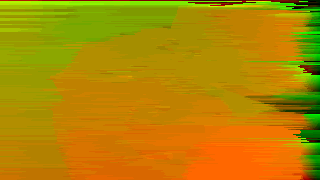

In [10]:
#k = np.ones((3,3))/9
#img_shift2[:,:,0] = ndimage.convolve(img_shift2[:,:,0], k, mode='reflect')
#img_shift2[:,:,1] = ndimage.convolve(img_shift2[:,:,1], k, mode='reflect')
Image.fromarray((255*img_shift2/img_shift2.max()).astype(np.uint8))

# lab2 start

https://staff.fnwi.uva.nl/l.dorst/hz/chap11_13.pdf

In [11]:
from random import choices
from scipy.linalg import null_space

In [12]:
def is_smooth(img_shift, x, y, radius=2):
    for i in range(-radius,radius+1):
        for j in range(-radius,radius+1):
            if np.any(img_shift[y, x] != img_shift[y+i, x+j]):
                return False
    return True


map2draw = np.zeros((img_r.shape), dtype=np.uint8)

pairs = []
rejected_pairs = []
# (X, X')
for y_r in range(30, img_r.shape[0] - 30):
    for x_r in range(30, img_r.shape[1] - 30):
        x_r3d = [x_r - img_r.shape[1]//2, y_r - img_r.shape[0]//2, 1]
        
        dot_shift = img_shift2[y_r, x_r]
        
        x_l = int(x_r + dot_shift[0])
        y_l = int(y_r + dot_shift[1])
        x_l3d = [x_l - img_r.shape[1]//2, y_l - img_r.shape[0]//2, 1]
        
        if is_smooth(img_shift2, x_r, y_r):
            pairs.append([x_l3d, x_r3d])
            map2draw[y_r, x_r] = 255
        else:
            rejected_pairs.append([x_l3d, x_r3d])

all_right = np.array([i[1] for i in pairs])
all_left = np.array([i[0] for i in pairs])

## Перевірка правильності пар точок

In [13]:
a = []
for r, l in zip(all_right, all_left):
    a.append(np.sum(np.abs(img_l[l[1]+img_r.shape[0]//2, l[0]+img_r.shape[1]//2] - img_r[r[1]+img_r.shape[0]//2, r[0]+img_r.shape[1]//2])))
print(sum(a)/len(a))

12.581967213114755


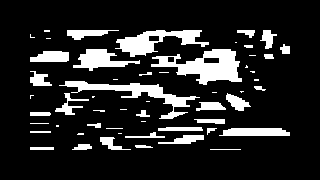

In [14]:
Image.fromarray(map2draw)

In [15]:
len(pairs)

8540

In [16]:
len(rejected_pairs)

22660

In [17]:
Boundary = 1e-6
bestF = None
bestScore = 0

all_right = np.array([i[1] for i in pairs])
all_left = np.array([i[0] for i in pairs])

for iteration in range(5000):
    seven_pairs = choices(pairs, k=7)
    X_big = []
    for left, right in seven_pairs:
        x_l, y_l, z_l = left
        x_r, y_r, z_r = right
        X_big.append([x_r*x_l, x_r*y_l, x_r*z_l,
                      y_r*x_l, y_r*y_l, y_r*z_l,
                      z_r*x_l, z_r*y_l, z_r*z_l])
        # на попередній лінії була помилка,
        # через яку я декілька тижнів не міг зрозуміти чого не працює.
        # вічна пам'ять моїм загиблим нервовим клітинам.
        # F
    X_big = np.array(X_big)
    null_vectors = null_space(X_big)
    f1 = null_vectors[:,0].reshape((3,3))
    f2 = null_vectors[:,1].reshape((3,3))
    
    p = np.array([
     np.linalg.det(f2),
     np.linalg.det(f2)*np.trace(np.dot(np.linalg.inv(f2), f1)),
     np.linalg.det(f1)*np.trace(np.dot(np.linalg.inv(f1), f2)),
     np.linalg.det(f1),
    # на попередній лінії була помилка,
    # через яку я декілька місяців не міг зрозуміти чого не працює.
    # вічна пам'ять моїм загиблим нервовим клітинам.
    # F
    ])
    coefs = np.roots(p)
    for i in coefs:
        if np.iscomplex(i):
            continue
        F = f1+float(i)*f2
        # both matrix have zero det
        score = np.sum(np.abs(np.einsum('ki,ij,kj->k', all_right, F, all_left)) < Boundary)
        if score > bestScore:
            bestScore = score
            bestF = F.copy()
            print("="*20)
            print("hit", bestScore/len(pairs))
            
            epipole = null_space(bestF, 1e-3)
            print(epipole)
            #epipole = epipole/epipole[-1]
            epipole_strich = [epipole[0,0], epipole[1,0]]
            print("X:", epipole_strich[0])
            print("Y:", epipole_strich[1])

hit 0.000819672131147541
[[-0.99619811]
 [ 0.08342917]
 [-0.02507773]]
X: -0.996198113271696
Y: 0.08342917081038645
hit 0.001053864168618267
[[ 0.085071  ]
 [-0.99628859]
 [ 0.01311381]]
X: 0.08507100387255705
Y: -0.9962885888519598
hit 0.311943793911007
[[-0.13789919]
 [ 0.99036693]
 [-0.01253629]]
X: -0.13789919177235624
Y: 0.9903669291405501
hit 0.4597189695550351
[[ 8.94427191e-01]
 [-4.47213595e-01]
 [ 2.77555756e-16]]
X: 0.8944271909999048
Y: -0.4472135954999804


/usr/lib/python3/dist-packages/ipykernel_launcher.py:40: ComplexWarning: Casting complex values to real discards the imaginary part


hit 0.5188524590163934
[[-7.07106781e-01]
 [ 7.07106781e-01]
 [-2.44249065e-15]]
X: -0.7071067811862057
Y: 0.707106781186889


## Фундаментальна матриця

In [18]:
np.round(bestF, 2)

array([[ 0.  , -0.  , -0.47],
       [ 0.  , -0.  , -0.47],
       [ 0.47,  0.47, -2.34]])

In [19]:
bestF

array([[ 5.44540541e-17, -1.53869972e-15, -4.67981591e-01],
       [ 1.50573998e-15, -8.53809211e-17, -4.67981591e-01],
       [ 4.67981591e-01,  4.67981591e-01, -2.33990795e+00]])

In [20]:
np.save("bestF.npy", bestF)
np.save("bestScore.npy", bestScore)

In [21]:
#bestF = np.load("bestF.npy")
#bestScore = np.load("bestScore.npy")

In [22]:
#with shelve.open("lab2.db") as db:
#    #db["bestF"] = bestF
#    #db["bestScore"] = bestScore
#    bestF = db["bestF"]
#    bestScore = db["bestScore"]
#    #img_shift2 = db["img_shift2"]

## Відсоток точок, які задовольняють умову до фундаментальної матриці

In [23]:
print(round(100*bestScore/len(pairs), 2),"%")

51.89 %


## Епіполярна точка у 3-х координатах

In [24]:
epipole = null_space(bestF, 1e-3)
epipole

array([[-7.07106781e-01],
       [ 7.07106781e-01],
       [-2.44249065e-15]])

In [25]:
epipole.reshape(3)

array([-7.07106781e-01,  7.07106781e-01, -2.44249065e-15])

In [26]:
np.linalg.det(bestF)

4.452142782645384e-19

## Ліве зображення

In [27]:
from PIL import ImageDraw

In [28]:
image2show = Image.fromarray(img_r.astype(np.uint8))
draw = ImageDraw.Draw(image2show)

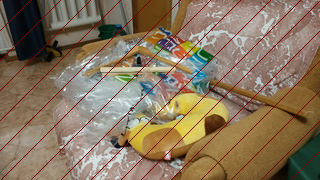

In [29]:
focus_x, focus_y = img_r.shape[1]//2, img_r.shape[0]//2

epipole2 = epipole.reshape(3) + np.array([img_r.shape[1]//2, img_r.shape[0]//2, 0])

x_img = img_r.shape[1]
for y_img in range(0, img_r.shape[0], 30):
    diff_vector = np.array([x_img, y_img, 1]) - epipole2.reshape(3)
    x_line1, y_line1, z_line1 = epipole2.reshape(3) + (1/3)*diff_vector
    x_line2, y_line2, z_line2 = epipole2.reshape(3) + (2/3)*diff_vector
    
    focus2point = np.array([x_line1, y_line1, z_line1]) - np.array([focus_x, focus_y, 0])
    projected_p1 = np.array([focus_x, focus_y, 0]) + focus2point*(1/focus2point[-1])

    focus2point = np.array([x_line2, y_line2, z_line2]) - np.array([focus_x, focus_y, 0])
    projected_p2 = np.array([focus_x, focus_y, 0]) + focus2point*(1/focus2point[-1])


    projected_diff = projected_p1 - projected_p2

    projected_p1 = projected_p1 - 1000*projected_diff
    projected_p2 = projected_p2 + 1000*projected_diff

    draw.line((*projected_p1[:-1], *projected_p2[:-1]), fill=128)

y_img = 0
for x_img in range(0, img_r.shape[1], 30):
    diff_vector = np.array([x_img, y_img, 1]) - epipole2.reshape(3)
    x_line1, y_line1, z_line1 = epipole2.reshape(3) + (1/3)*diff_vector
    x_line2, y_line2, z_line2 = epipole2.reshape(3) + (2/3)*diff_vector

    focus2point = np.array([x_line1, y_line1, z_line1]) - np.array([focus_x, focus_y, 0])
    projected_p1 = np.array([focus_x, focus_y, 0]) + focus2point*(1/focus2point[-1])

    focus2point = np.array([x_line2, y_line2, z_line2]) - np.array([focus_x, focus_y, 0])
    projected_p2 = np.array([focus_x, focus_y, 0]) + focus2point*(1/focus2point[-1])

    projected_diff = projected_p1 - projected_p2

    projected_p1 = projected_p1 - 1000*projected_diff
    projected_p2 = projected_p2 + 1000*projected_diff

    draw.line((*projected_p1[:-1], *projected_p2[:-1]), fill=128)
    
image2show